In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [9]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [10]:
model = StyleModel()
model.load_state_dict(torch.load('../model/TestData_StyleModel.pt'))

<All keys matched successfully>

In [11]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [03:01<00:00, 58.78it/s]


## Centroids

In [12]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [13]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,1.860,1.847,1.940,1.878,1.952,1.936
1,0.000,0.000,0.285,0.516,0.285,0.374,0.305
2,0.000,0.000,0.000,0.505,0.181,0.259,0.228
3,0.000,0.000,0.000,0.000,0.512,0.554,0.503
4,0.000,0.000,0.000,0.000,0.000,0.281,0.208
5,0.000,0.000,0.000,0.000,0.000,0.000,0.192
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

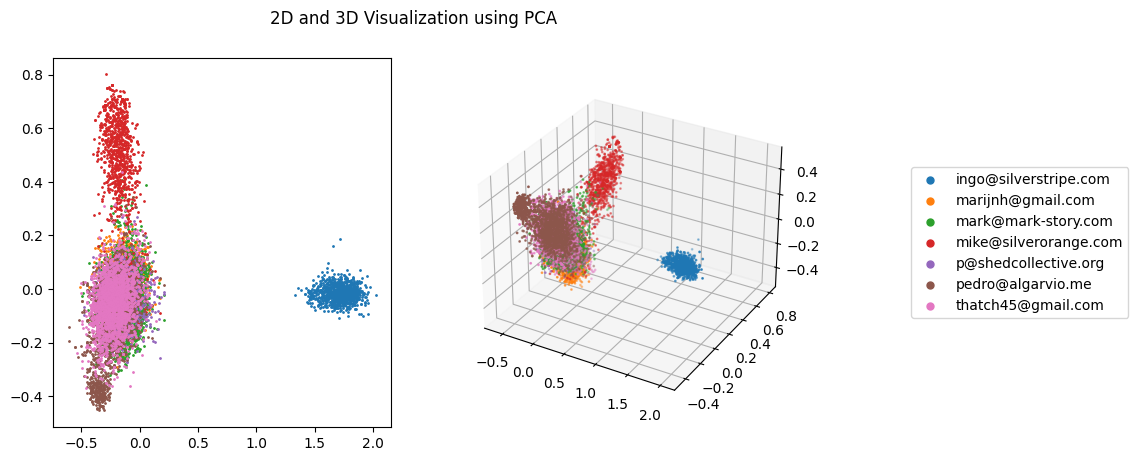

In [14]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

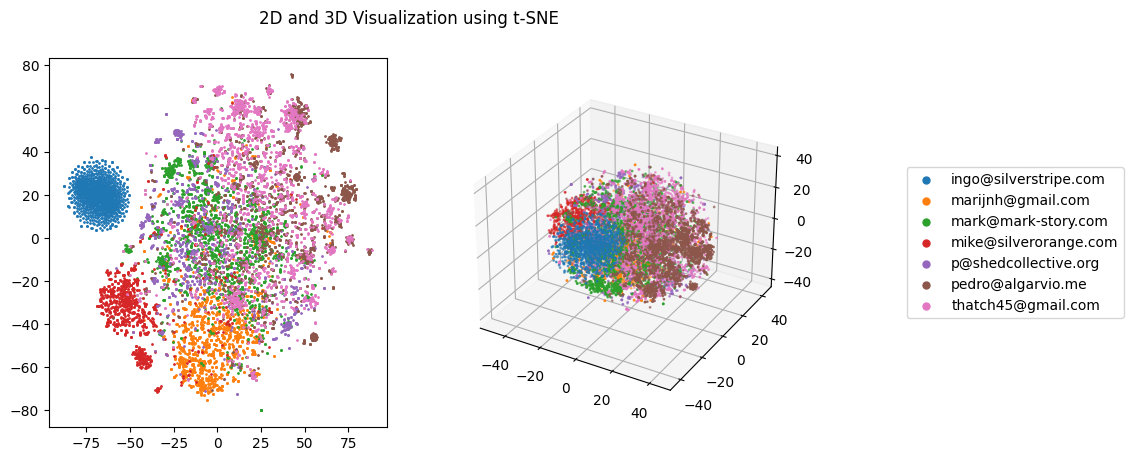

In [15]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

% TODO: - Describe DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 3
10 Most common:
[(1, 5907), (-1, 3771), (0, 1006)]


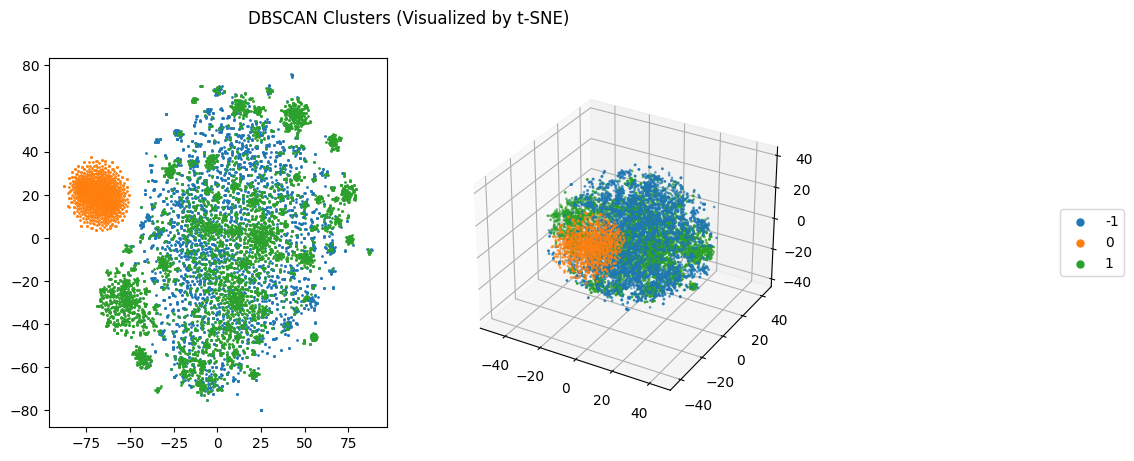

In [16]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [17]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,3771.0,6.0,628.5,"('thatch45@gmail.com', 1051)",56.0,67.339286,"('saltstack_salt', 1572)"
1,1006.0,1.0,1006.0,"('ingo@silverstripe.com', 1006)",29.0,34.689655,"('silverstripe_silverstripe-framework', 605)"
2,5907.0,6.0,984.5,"('mark@mark-story.com', 1417)",56.0,105.482143,"('saltstack_salt', 2226)"


In [18]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,3561.333333,4.333333,873.000000,47.000000,69.170361
std,2457.218007,2.886751,212.015919,15.588457,35.431747
min,1006.000000,1.000000,628.500000,29.000000,34.689655
25%,2388.500000,3.500000,806.500000,42.500000,51.014470
50%,3771.000000,6.000000,984.500000,56.000000,67.339286
75%,4839.000000,6.000000,995.250000,56.000000,86.410714
max,5907.000000,6.000000,1006.000000,56.000000,105.482143


In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

def clustering_spacy_evaluation(predictions, data):
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe('spacytextblob')

    spacy_summary = pd.DataFrame(
        columns=[str(label) for label in sorted(list(set(predictions)))],
        index=['polarity_mean', 'polarity_std', 'subjectivity_mean', 'subjectivity_std'])

    if np.isin(-1, predictions):
        predictions += 1
    
    for label in sorted(list(set(predictions))):
        messages = data['message'].where(predictions == label)
        docs = nlp.pipe(messages)
        
        lengths = []
        n_upper_case_letters = []
        polarities = []
        subjectivities = []

        for i in range(len(messages)):
            lengths.append(len(messages[i]))
            n_upper_case_letters.append(sum(1 for c in messages[i] if c.isupper()))
            polarities.append(docs[i]._.blob.polarity)
            subjectivities.append(docs[i]._.blob.subjectivity)

        spacy_summary[str(label)]['polarity_mean'] = np.mean(polarities)
        spacy_summary[str(label)]['polarity_std'] = np.std(polarities)
        spacy_summary[str(label)]['subjectivity_mean'] = np.mean(subjectivities)
        spacy_summary[str(label)]['subjectivity_std'] = np.std(subjectivities)

    return spacy_summary

In [ ]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

In [19]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Take inclusiveLeft/Right into account when preventing editing of readOnly spans
___
2) 
Another refinement to Rhino-detection

Issue #<I>
___
3) 
prevent line numbers from confusing click-position-detection
___
4) 
[stex mode] Reposition some else lines to match coding style
___
5) 
Properly export rebaseSteps from collab module
___
6) 
Allow directly passing nodes and styles to Schema constructor
___
7) 
[rust mode] Fix problem with parsing of alt
___
8) 
Hack to work around Safari crash on setDragImage

Closes #<I>
___
9) 
Define replaceSelection in a simpler way by using new empty node rules
___
10) 
Make Chinese and Japanese characters count as word characters
_________________

Number of messages in this class: 3771
Most common author:
('thatch45@gmail.com', 1051)
Most common project:
('saltstack_salt', 1572)



________________ Class 1 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed du

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(0, 3152), (2, 2451), (5, 1781), (1, 1006), (4, 925), (6, 873), (3, 496)]


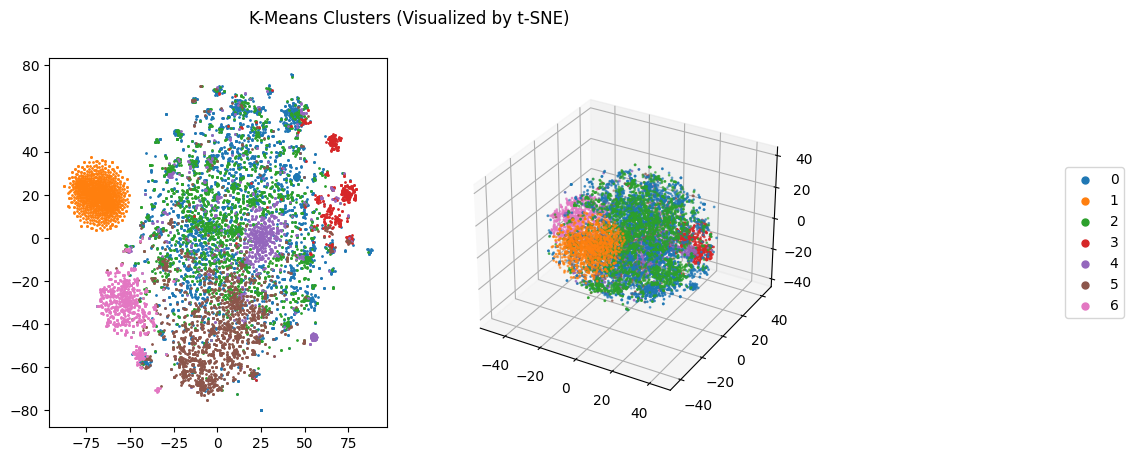

In [20]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [21]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,3152.0,6.0,525.333333,"('thatch45@gmail.com', 1109)",54.0,58.370370,"('saltstack_salt', 1739)"
1,1006.0,1.0,1006.000000,"('ingo@silverstripe.com', 1006)",29.0,34.689655,"('silverstripe_silverstripe-framework', 605)"
2,2451.0,6.0,408.500000,"('mark@mark-story.com', 901)",50.0,49.020000,"('saltstack_salt', 906)"
3,496.0,4.0,124.000000,"('pedro@algarvio.me', 392)",7.0,70.857143,"('saltstack_salt', 481)"
4,925.0,6.0,154.166667,"('mark@mark-story.com', 461)",22.0,42.045455,"('cakephp_cakephp', 448)"
5,1781.0,6.0,296.833333,"('marijnh@gmail.com', 1046)",40.0,44.525000,"('codemirror_CodeMirror', 828)"
6,873.0,5.0,174.600000,"('mike@silverorange.com', 846)",5.0,174.600000,"('silverorange_swat', 846)"


In [22]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,4.857143,384.204762,29.571429,67.729660
std,973.262163,1.864454,310.732687,19.552128,48.577215
min,496.000000,1.000000,124.000000,5.000000,34.689655
25%,899.000000,4.500000,164.383333,14.500000,43.285227
50%,1006.000000,6.000000,296.833333,29.000000,49.020000
75%,2116.000000,6.000000,466.916667,45.000000,64.613757
max,3152.000000,6.000000,1006.000000,54.000000,174.600000


In [23]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Allow directly passing nodes and styles to Schema constructor
___
2) 
Make Chinese and Japanese characters count as word characters
___
3) 
Add OS X keybindings
___
4) 
Temporarily export enough internals from DOM conversion to allow extension
___
5) 
[groovy mode] Properly consume dotted names in attributes
___
6) 
[foldcode addon] Add an isFolded method
___
7) 
Make contains shadow-dom aware, and export it
___
8) 
Fix def.parse to actually return something when parsing object type
___
9) 
Replace pre-command event with a ranked keymap

In inputrules module
___
10) 
Allow passing in a goalColumn to findPosV
_________________

Number of messages in this class: 3152
Most common author:
('thatch45@gmail.com', 1109)
Most common project:
('saltstack_salt', 1739)



________________ Class 1 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from